In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Abstract

Display project.
<br>
**Goal**: Create model that predicts whether a passenger would survive the crash of Titanic
<br>
**Aproach**: Using PACE framework, I started with gaining some insights from the data, then performed EDA and feature engineering to prepare them for modeling. During modeling I used 3 different models (Logistic Regression, Random Forest, XGBoost) then using metrics evaluation, I applied the best performing on my validation set. After tuning hyperparameters I applied it on the test set.

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# **Data Overview** 
<br>
1. Survived: Indicates if a passenger survived (1) or not (0).
<br>
2. Pclass: Ticket class, a proxy for socio-economic status (1 = 1st, 2 = 2nd, 3 = 3rd).
<br>
3. Name: Passenger's name.
<br>
4. Sex: Passenger's sex.
<br>
5. Age: Passenger's age in years. (missing values)
<br>
6. SibSp: Number of siblings/spouses aboard the Titanic.
<br>
7. Parch: Number of parents/children aboard the Titanic.
<br>
8. Ticket: Ticket number.
<br>
9. Fare: Passenger fare. (missing values)
<br>
10. Cabin: Cabin number. (missing values)
<br>
11. Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton). 

In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The mean for **Survived** is 0.3838 indicating the less than half of the passengers survived. However, its not a crazy imbalance.
<br>
The mean for **Pclass** is 2.30 indicating that the majority of the passenger are 2nd and 3rd class
<br>
The min for **Age** is 0.42 representing the youngest person onboard and the max is 80 representing the oldest person with a mean age of 29.69 years old.
<br>
The max for **Fare** is 512.32 when the mean is 32.20 indicating that there's probably outliers
<br>
The mean for **SibSp** and **Parch** is 0.52 and 0.38 accordingly indicating that most passengers don't have other people with them.

**Concatenate data**

In [6]:
combined_data = pd.concat([train_data, test_data], axis = 0, ignore_index = True)
combined_data.index = combined_data.index + 1

## Missing Values
* Cabin
* Fare
* Age
* Embarked
<br>
<br>
Let's start with Cabin. It seems like almost 80% is missing values, however we could use Cabin in an alternative way. We could extract a status of having or not having a cabin as well as extracting the deck which the cabin is on.

In [7]:
combined_data.loc[(combined_data['Cabin'].isnull()),'Cabin_status'] = 0
combined_data.loc[(combined_data['Cabin'].notnull()),'Cabin_status']=1
combined_data.Cabin_status.astype('int')

1       0
2       1
3       0
4       1
5       0
       ..
1305    0
1306    1
1307    0
1308    0
1309    0
Name: Cabin_status, Length: 1309, dtype: int64

In [8]:
combined_data['Deck'] = combined_data['Cabin'].str[0]
combined_data.loc[combined_data['Deck'].isna(), 'Deck'] = 'Unknown'
combined_data['Deck'].value_counts()

Deck
Unknown    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: count, dtype: int64

<Axes: xlabel='Deck', ylabel='count'>

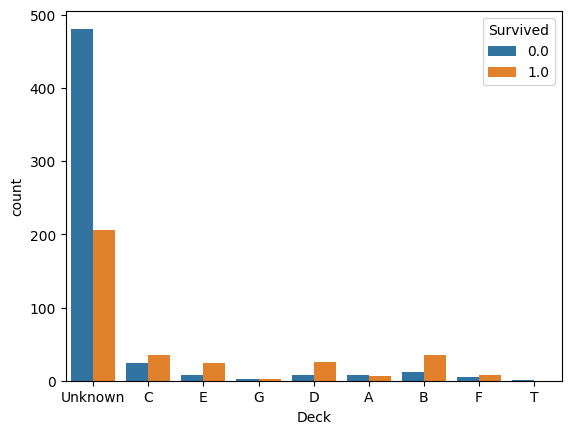

In [9]:
sns.countplot(combined_data, x = 'Deck', hue = 'Survived')

In [10]:
combined_data['Deck'] = combined_data['Deck'].map({'Unknown': 0, 'C': 1, 'E': 2, 'G': 3, 'D': 4,
                                                   'A': 5, 'B': 6, 'F': 7, 'T': 8})

**Fare**

Since there's only one missing value on the test set, we will fill this value with the mean of the test set.

In [11]:
mean_fare = test_data['Fare'].mean()
combined_data['Fare'] = combined_data['Fare'].fillna(mean_fare)
print(mean_fare)

35.627188489208635


Fare seems to have outliers.

<Axes: xlabel='Fare'>

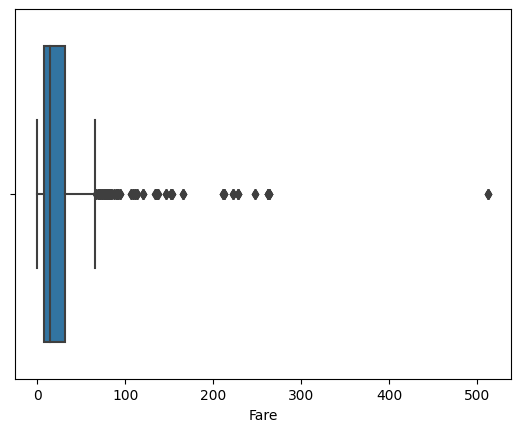

In [12]:
sns.boxplot(combined_data, x = 'Fare')

To deal with outliers we will replace values over 200 with the mean_fare of the combined data.

In [13]:
mean_fare = combined_data['Fare'].mean()
combined_data.loc[combined_data['Fare'] > 200, 'Fare'] = mean_fare

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Fare', ylabel='Count'>

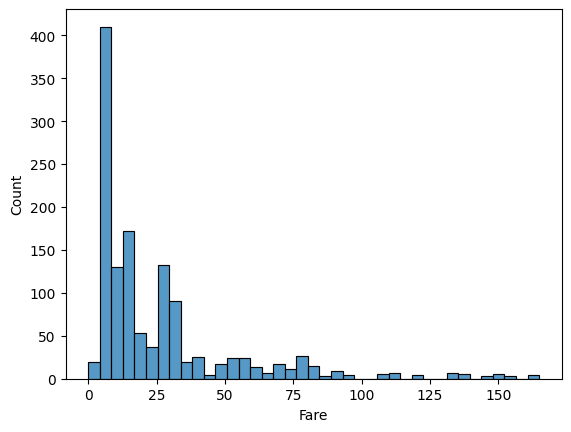

In [14]:
sns.histplot(combined_data, x = 'Fare')

**Age**

To figure out the best way to impute age, I'm using a correlation matrix which shows me that **Pclass** is closely related with age. Then I use it to fill the missing values

In [15]:
correlation_matrix = combined_data.drop(columns = ['Ticket', 'PassengerId', 'Name', 'Embarked', 'Cabin', 'Sex']).corr()
age_correlation = correlation_matrix['Age'].sort_values(ascending=False)
print('Top correlated features with age: ')
print(age_correlation)

Top correlated features with age: 
Age             1.000000
Cabin_status    0.289740
Deck            0.196669
Fare            0.181223
Survived       -0.077221
Parch          -0.150917
SibSp          -0.243699
Pclass         -0.408106
Name: Age, dtype: float64


In [16]:
combined_data['Age'] = combined_data['Age'].fillna(combined_data.groupby('Pclass')['Age'].transform('median'))

**Embarked**

There are only 2 missing values on the training set and we can use the pclass to fill them.

In [17]:
combined_data[combined_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_status,Deck
62,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1.0,6
830,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1.0,6


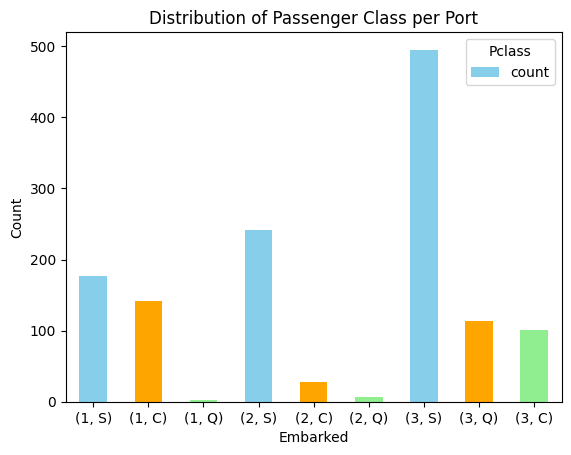

In [18]:
class_distribution_per_port = combined_data.groupby('Pclass')['Embarked'].value_counts()

class_distribution_per_port.plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'lightgreen'])
plt.title('Distribution of Passenger Class per Port')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Pclass')

plt.show()

We can see that the big majority of people that are in first class seem to have boarded on port 'S'

In [19]:
combined_data['Embarked'] = combined_data['Embarked'].fillna('S')

Checking for missing values shows us that we've dealt with the missing values, since the 418 Survived nan values are there because of the concatenation.

In [20]:
combined_data = combined_data.drop(columns = 'Cabin')

In [21]:
print(combined_data.isna().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Embarked          0
Cabin_status      0
Deck              0
dtype: int64


In [22]:
combined_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_status,Deck
1,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0.0,0
2,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1.0,1
3,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0.0,0
4,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1.0,1
5,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0.0,0


# Feature Engineering

**Title**
<br>
The name column seems of no interest, however it can be used to extract the title which might help the model's prediction.

In [23]:
combined_data['Title'] = combined_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [24]:
combined_data['Title'].value_counts()

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

There's a lot of title that are rarely found on the data set as well as titles that could be assigned to a general title, so let's group the title feature.

In [25]:
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 
               'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
combined_data['Title'] = combined_data['Title'].replace(rare_titles, 'Rare')
combined_data['Title'] = combined_data['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

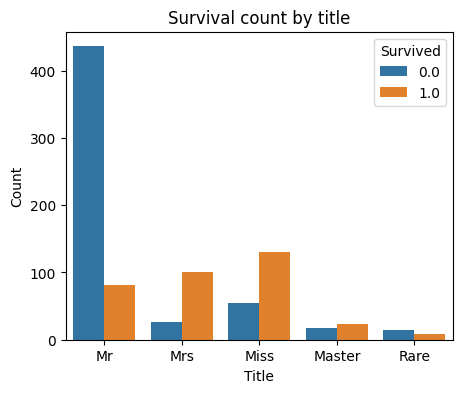

In [26]:
plt.figure(figsize = (5, 4))
sns.countplot(data = combined_data, x = 'Title', hue = 'Survived')
plt.title('Survival count by title')
plt.xlabel('Title')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.show()

**Family Size**
<br>
By adding the **SibSp** and the **Parch** we can compute the size of the family.
<br>
We can use this feature to check if the person is alone or if it's a duo.

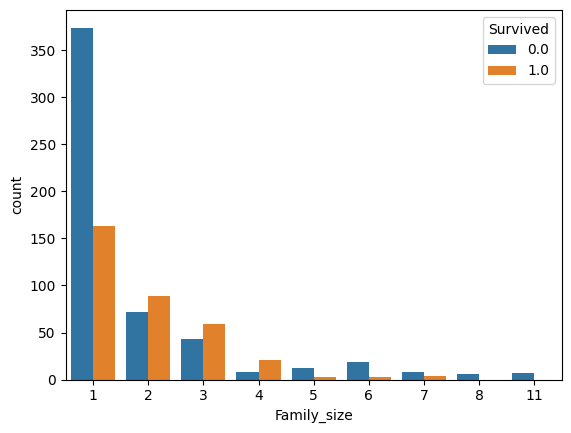

In [27]:
combined_data['Family_size'] = combined_data['SibSp'] + combined_data['Parch'] + 1
sns.countplot(combined_data, x = 'Family_size', hue = 'Survived')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Family_size_bin', ylabel='count'>

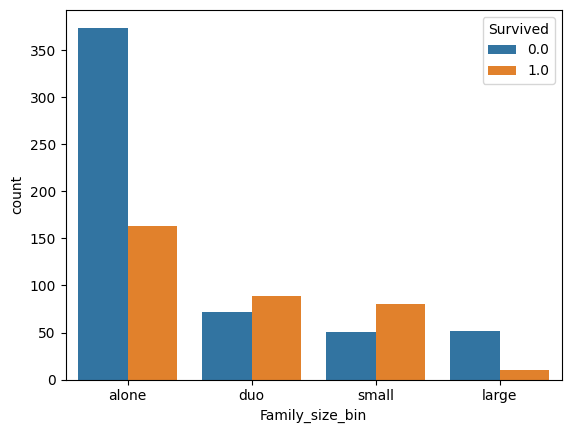

In [28]:
bins = [0, 1, 2, 4, 11]
labels = ['alone', 'duo', 'small', 'large']
combined_data['Family_size_bin'] = pd.cut(combined_data['Family_size'], bins = bins, labels = labels)
sns.countplot(combined_data, x = 'Family_size_bin', hue = 'Survived')

**Age Group**

On the following chart we can see that there are some age ranges that could be grouped.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='Age', ylabel='Count'>

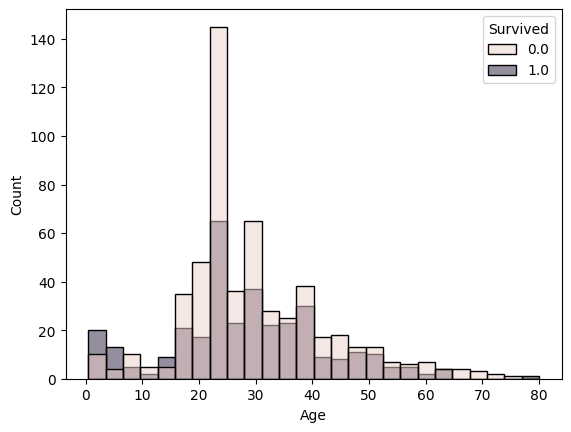

In [29]:
sns.histplot(combined_data, x = 'Age', hue = 'Survived')

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Age_grouped', ylabel='count'>

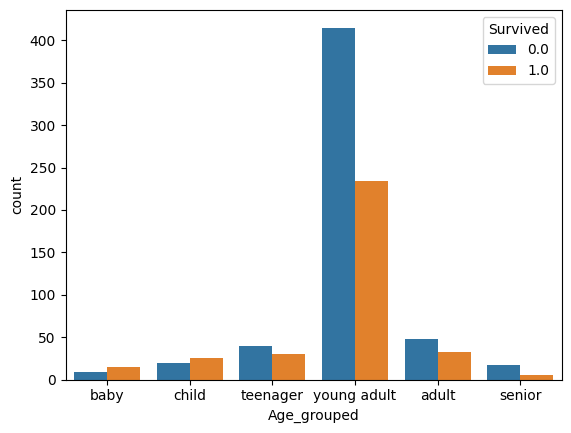

In [30]:
bins = [0, 2, 12, 18, 45, 60, np.inf]
labels = ['baby', 'child', 'teenager', 'young adult', 'adult', 'senior']
combined_data['Age_grouped'] = pd.cut(combined_data['Age'], bins = bins, labels = labels)
sns.countplot(combined_data, x = 'Age_grouped', hue = 'Survived')

**Fare group**
<br>
It appears like we could create some groups for the feature 'Fare', which is highly skewed.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Fare', ylabel='Count'>

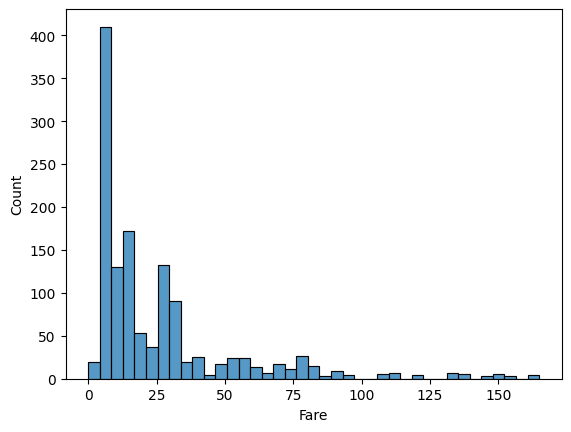

In [31]:
sns.histplot(combined_data, x = 'Fare')

In [32]:
combined_data['Fare_bin'] = pd.qcut(combined_data['Fare'], q=5, labels=False)

<Axes: xlabel='Fare_bin', ylabel='count'>

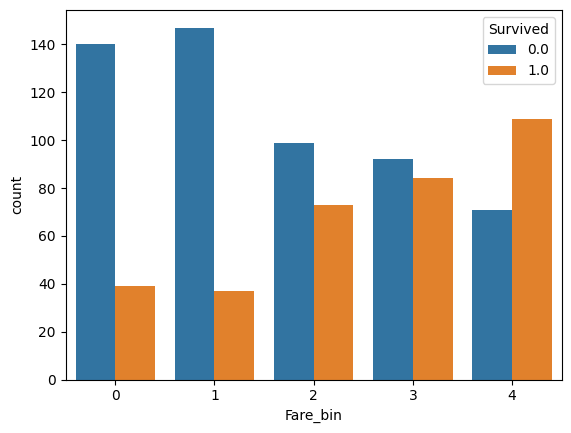

In [33]:
sns.countplot(combined_data, x = 'Fare_bin', hue = 'Survived')

**Ticket feature engineering**

<br>
Let's start by using the frequency of the tickets which will give us the number of passengers that share the same ticket.

In [34]:
combined_data['Ticket_Frequency'] = combined_data.groupby('Ticket')['Ticket'].transform('count')

<Axes: xlabel='Ticket_Frequency', ylabel='count'>

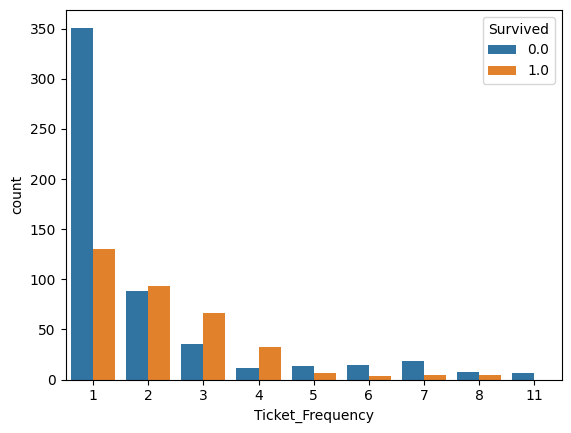

In [35]:
sns.countplot(combined_data, x = 'Ticket_Frequency', hue = 'Survived')

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Ticket_frequency_bin', ylabel='count'>

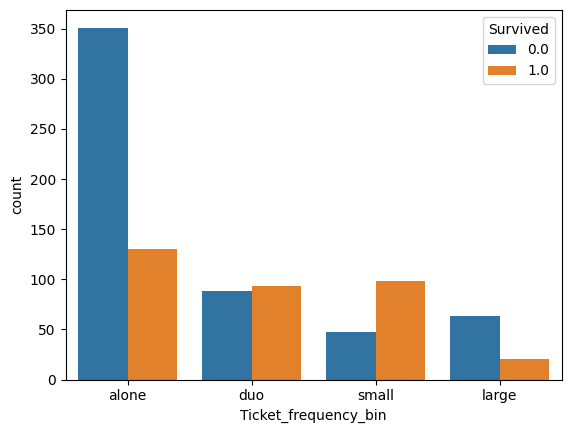

In [36]:
bins = [0, 1, 2, 4, 11]
labels = ['alone', 'duo', 'small', 'large']
combined_data['Ticket_frequency_bin'] = pd.cut(combined_data['Ticket_Frequency'], bins = bins, labels = labels)
sns.countplot(combined_data, x = 'Ticket_frequency_bin', hue = 'Survived')

# Encoding categoricals 

Let's encode our categorical features.

Before we begin though we can drop the Name, Ticket and PassengerId column since they are of no use.

In [37]:
combined_data = combined_data.drop(columns = ['PassengerId', 'Name', 'Ticket'])

In [38]:
combined_data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_status,Deck,Title,Family_size,Family_size_bin,Age_grouped,Fare_bin,Ticket_Frequency,Ticket_frequency_bin
1,0.0,3,male,22.0,1,0,7.2500,S,0.0,0,Mr,2,duo,young adult,0,1,alone
2,1.0,1,female,38.0,1,0,71.2833,C,1.0,1,Mrs,2,duo,young adult,4,2,duo
3,1.0,3,female,26.0,0,0,7.9250,S,0.0,0,Miss,1,alone,young adult,1,1,alone
4,1.0,1,female,35.0,1,0,53.1000,S,1.0,1,Mrs,2,duo,young adult,4,2,duo
5,0.0,3,male,35.0,0,0,8.0500,S,0.0,0,Mr,1,alone,young adult,1,1,alone


The features that need to be encoded are:

* Sex (binary: male - female)
* Embarked (S - Q - C)
* Title (Mr - Mrs - Miss - Master - Rare)
* Family_size_bin (alone, duo, small, medium, large)
* Age grouped (baby, child, teenager, young adult, adult, senior)
* Fare bin
* Ticket frequency bin (alone, duo, small, medium, large)


In [39]:
combined_data = pd.get_dummies(combined_data, columns = ['Sex', 'Embarked', 'Title', 'Family_size_bin', 'Fare_bin', 'Pclass', 'Age_grouped', 'Ticket_frequency_bin'], drop_first = True)

In [40]:
##combined_data['Sex'] = combined_data['Sex'].map({'male': 0, 'female': 1})
##combined_data['Embarked'] = combined_data['Embarked'].map({'S': 1, 'Q': 2, 'C': 3})
##combined_data['Title'] = combined_data['Title'].map({'Mr': 1, 'Mrs': 2, 'Miss': 3, 'Master': 4, 'Rare': 5})
##combined_data['Family_size_grouped'] = combined_data['Family_size_grouped'].map({'alone': 1, 'small': 2, 'medium': 3, 'large': 4}).astype('int')
##combined_data['Age_grouped'] = combined_data['Age_grouped'].map({'baby': 1, 'child': 2, 'teenager': 3, 'young adult': 4, 'adult': 5, 'senior': 6}).astype('int')

In [41]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 1 to 1309
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Survived                    891 non-null    float64
 1   Age                         1309 non-null   float64
 2   SibSp                       1309 non-null   int64  
 3   Parch                       1309 non-null   int64  
 4   Fare                        1309 non-null   float64
 5   Cabin_status                1309 non-null   float64
 6   Deck                        1309 non-null   int64  
 7   Family_size                 1309 non-null   int64  
 8   Ticket_Frequency            1309 non-null   int64  
 9   Sex_male                    1309 non-null   bool   
 10  Embarked_Q                  1309 non-null   bool   
 11  Embarked_S                  1309 non-null   bool   
 12  Title_Miss                  1309 non-null   bool   
 13  Title_Mr                    1309 

In [42]:
combined_data.head()

,Survived,Age,SibSp,Parch,Fare,Cabin_status,Deck,Family_size,Ticket_Frequency,Sex_male,...,Pclass_2,Pclass_3,Age_grouped_child,Age_grouped_teenager,Age_grouped_young adult,Age_grouped_adult,Age_grouped_senior,Ticket_frequency_bin_duo,Ticket_frequency_bin_small,Ticket_frequency_bin_large
1,0.0,22.0,1,0,7.2500,0.0,0,2,1,True,...,False,True,False,False,True,False,False,False,False,False
2,1.0,38.0,1,0,71.2833,1.0,1,2,2,False,...,False,False,False,False,True,False,False,True,False,False
3,1.0,26.0,0,0,7.9250,0.0,0,1,1,False,...,False,True,False,False,True,False,False,False,False,False
4,1.0,35.0,1,0,53.1000,1.0,1,2,2,False,...,False,False,False,False,True,False,False,True,False,False
5,0.0,35.0,0,0,8.0500,0.0,0,1,1,True,...,False,True,False,False,True,False,False,False,False,False


Now that are features are all numerical we can use a correlation heatmap to see what are the most influential features.

Text(0.5, 1.0, 'Correlation Heatmap')

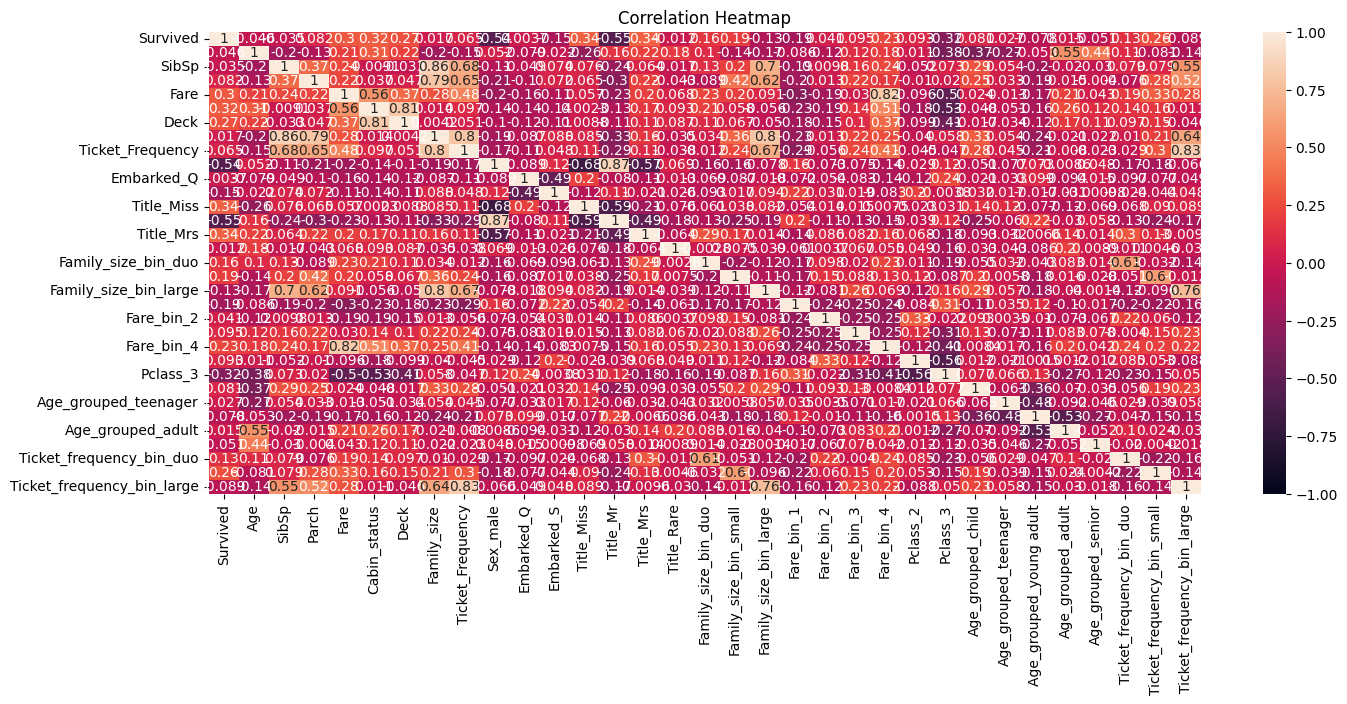

In [43]:
plt.figure(figsize = (16, 6))
sns.heatmap(combined_data.corr(), vmin = -1, vmax = 1, annot = True)
plt.title('Correlation Heatmap')

Let's drop columns, to avoid high correlation between data that can ruin our model's performance.

In [44]:
combined_data = combined_data.drop(columns = ['Age', 'Family_size', 'Ticket_Frequency', 'SibSp', 'Parch'])

Now lets divide our combined data back to train and test sets

In [45]:
# Slice the combined data to create train and test datasets
df_train = combined_data.iloc[:len(train_data)].copy()
df_train['Survived'] = combined_data[:len(train_data)]['Survived']
df_test = combined_data.iloc[len(train_data):].copy()
df_test = df_test.drop(columns = 'Survived')
df_test.head()

,Fare,Cabin_status,Deck,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,...,Pclass_2,Pclass_3,Age_grouped_child,Age_grouped_teenager,Age_grouped_young adult,Age_grouped_adult,Age_grouped_senior,Ticket_frequency_bin_duo,Ticket_frequency_bin_small,Ticket_frequency_bin_large
892,7.8292,0.0,0,True,True,False,False,True,False,False,...,False,True,False,False,True,False,False,False,False,False
893,7.0000,0.0,0,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
894,9.6875,0.0,0,True,True,False,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False
895,8.6625,0.0,0,True,False,True,False,True,False,False,...,False,True,False,False,True,False,False,False,False,False
896,12.2875,0.0,0,False,False,True,False,False,True,False,...,False,True,False,False,True,False,False,True,False,False


**Modeling**
<br>
For this project we are going to cross validate Logistic Regression, Random Forest, XGBoost and tune their parameters through GridSearhCV.

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

In [47]:
y = df_train['Survived']
X = df_train.drop(columns = 'Survived')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, stratify = y, random_state = 42)
X_test = df_test

In [48]:
kfold = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 42)

In [49]:
models = {
    "Logistic Regression": LogisticRegression(max_iter = 1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

scoring = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'accuracy': 'accuracy',
           'roc_auc': 'roc_auc'}

**Cross validating the models**

Looping through the models and using cross validation to find the best one.

In [50]:
%%time
mean_results = {}

# Loop over models
for name, model in models.items():
    # Perform cross-validation on the training data
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    
    # Calculate mean results for each metric
    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring}
    
    # Store mean results in the dictionary
    mean_results[name] = mean_scores

# Create DataFrame from mean results dictionary
results_df = pd.DataFrame(mean_results).T

# Print the results DataFrame
print("Mean Results:")
print(results_df)

Mean Results:
                     precision    recall        f1  accuracy   roc_auc
Logistic Regression   0.801523  0.745529  0.770909  0.830960  0.870273
Random Forest         0.806422  0.742022  0.765982  0.829618  0.884844
XGBoost               0.814299  0.752367  0.774681  0.834934  0.902800
CPU times: user 5.43 s, sys: 1.52 s, total: 6.95 s
Wall time: 2.88 s


We are using the f1 metric to define the best performing model.

**Random Forest**

In [51]:
# %%time
# param_grid = {
#     'n_estimators': [100, 200, 300, 400],  
#     'max_depth': [None, 10, 20],        
#     'min_samples_split': [2, 5, 10],    
#     'min_samples_leaf': [1, 2, 4]       
# }


# rf_model = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kfold, scoring='f1', n_jobs = -1)

# grid_search.fit(X_train, y_train)

# print("Best Hyperparameters:", grid_search.best_params_)

# best_rf_model = grid_search.best_estimator_

**XGBoost**

In [52]:
%%time
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

xgb_model = XGBClassifier(random_state = 42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=kfold, scoring='f1', n_jobs = -1)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
CPU times: user 1.25 s, sys: 121 ms, total: 1.37 s
Wall time: 13.1 s


**Logistic Regression**

In [53]:
# %%time
# param_grid = {
#     'penalty': ['l2'],
#     'C': [0.01, 0.1, 1, 10, 100]        
# }

# logistic_model = LogisticRegression(random_state=42, max_iter = 800)

# grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=kfold, scoring='f1', n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best Hyperparameters:", grid_search.best_params_)

# best_logistic_model = grid_search.best_estimator_

**Validation set**
<br>
Let's use the validation set to see how our model performs on data that hasn't seen before.

In [54]:
model = best_xgb_model
#model = best_rf_model
#model = best_logistic_model
y_pred = model.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82        83
         1.0       0.72      0.67      0.69        51

    accuracy                           0.78       134
   macro avg       0.76      0.76      0.76       134
weighted avg       0.77      0.78      0.77       134

Accuracy: 0.7761194029850746
ROC AUC: 0.7550200803212851


Confusion matrix

<Figure size 800x600 with 0 Axes>

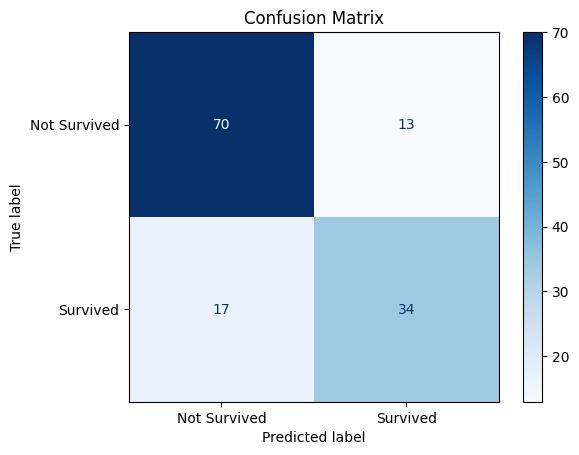

In [55]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived', 'Survived']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

**Feature importance**
<br>
Using the random forest best model we can see the most importnat features. This helps with refining the feature engineering as well as removing features that don't really have an impact on our model, making it faster and reduce computational complexity.

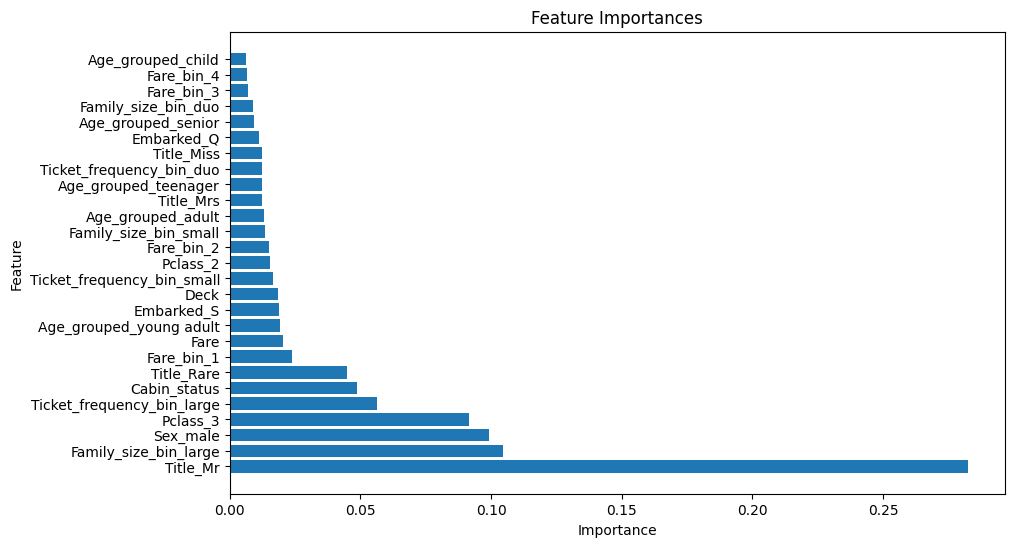

In [56]:
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

**Apply on the test data and submission**

In [57]:
# Make predictions on the test data
y_pred_test = model.predict(X_test)

submission_df = pd.DataFrame({
    'PassengerId': X_test.index,
    'Survived': y_pred_test.astype('int')
})

# Save the DataFrame to a CSV file
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

print("CSV file created successfully.")

CSV file created successfully.


**Results**
<br>0.79186
On this version the best performing model is **Random Forest** and when applied on the test set we get a score of **0.79186**